# Import learning data

In [1]:
import pandas as pd

data_path = "../learning_data/data/win_rate/river/100-data-100-simulation-2-players-win-rate-data.csv"
df = pd.read_csv(data_path)

# About learning data

In [2]:
df.shape

(100, 15)

In [3]:
df.head()

,hole1,hole2,community1,community2,community3,community4,community5,win_rate,hole1_id,hole2_id,community1_id,community2_id,community3_id,community4_id,community5_id
0,D9,S9,H4,C8,H3,CK,H7,0.68,22,48,30,8,29,13,33
1,C8,DQ,S5,S4,D4,HK,C3,0.40,8,25,44,43,17,39,3
2,HJ,SQ,S9,H6,S6,CA,S3,0.44,37,51,48,32,45,1,42
3,S5,SK,CA,CT,C3,DA,D4,0.46,44,52,1,10,3,14,17
4,D5,D3,HT,CJ,CK,H2,S8,0.01,18,16,36,11,13,28,47


In [4]:
df.describe()

,win_rate,hole1_id,hole2_id,community1_id,community2_id,community3_id,community4_id,community5_id
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.573900,24.670000,24.760000,28.390000,23.850000,27.230000,28.330000,28.420000
std,0.250058,15.159792,15.413571,15.966439,15.075818,15.737015,14.587289,13.665691
min,0.010000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.447500,10.000000,12.000000,16.000000,10.000000,13.000000,15.000000,20.000000
50%,0.545000,24.000000,22.000000,32.000000,22.000000,28.500000,30.000000,29.000000
75%,0.750000,37.000000,39.000000,42.250000,36.000000,41.000000,41.000000,37.250000
max,1.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000


# Data Processing

## card id -> 1-hot vector

In [5]:
import numpy as np

gen_one_hot = lambda target_ids: [1 if i in target_ids else 0 for i in range(1,53)]
fetch_hole = lambda row: [row[key] for key in ['hole1_id', 'hole2_id']]
fetch_community = lambda row: [row[key] for key in ['community1_id', 'community2_id', 'community3_id', 'community4_id', 'community5_id']]
hole_one_hot = df.apply(lambda row: gen_one_hot(fetch_hole(row)), axis=1)
community_one_hot = df.apply(lambda row: gen_one_hot(fetch_community(row)), axis=1)
df["onehot"] = hole_one_hot + community_one_hot

## Separate data for training and validation

In [8]:
validation_rate = 0.1
boundary_idx = int(df.shape[0]*(1-validation_rate))
train_df = df[:boundary_idx]
validation_df = df[boundary_idx:]

## Format data (pandas.df -> numpy.ndarray)

In [9]:
to_ndarray = lambda X: np.array([np.array(x) for x in X])
train_x, train_y = [to_ndarray(array) for array in [train_df["onehot"].values, train_df["win_rate"].values]]
val_x, val_y = [to_ndarray(array) for array in [validation_df["onehot"].values, validation_df["win_rate"].values]]
print "shape of training x: %s, y: %s" % (train_x.shape, train_y.shape)
print "shape of validation x: %s, y: %s" % (val_x.shape, val_y.shape)

shape of training x: (90, 104), y: (90,)
shape of validation x: (10, 104), y: (10,)


# Create model

In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

model = Sequential()
model.add(Dense(60, input_dim=104))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss="mse",  optimizer="rmsprop")

Using Theano backend.


# Train model

In [11]:
history = model.fit(train_x, train_y, batch_size=128, nb_epoch=100, validation_split=0.1, verbose=0)

# Check model performance

## Visualize loss transition

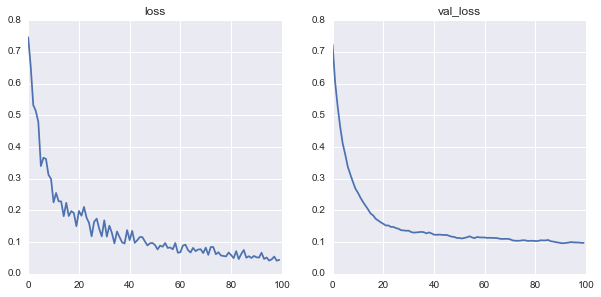

In [12]:
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for idx, key in enumerate(history.history, start=1):
    plt.subplot(2, 2, idx)
    plt.plot(range(len(history.history[key])), history.history[key])
    plt.title(key)
plt.show()

## Test model performance by MSE 

In [13]:
from sklearn.metrics import mean_squared_error

def print_model_performance(model, train_x, train_y, val_x, val_y):
    print 'MSE on training data = {score}'.format(score=mean_squared_error(model.predict(train_x), train_y))
    print 'MSE on validation data = {score}'.format(score=mean_squared_error(model.predict(val_x), val_y))

In [14]:
print_model_performance(model, train_x, train_y, val_x, val_y)

MSE on training data = 0.0161681796177
MSE on validation data = 0.04834510794


## See model prediction on sample data

In [20]:
from pypokerengine.engine.card import Card
C, D, H, S = Card.CLUB, Card.DIAMOND, Card.HEART, Card.SPADE

test_case = [
    [(11, H), (7, S), (12, H), (6, S), (1, H), (10, H), (13, H), 1.0],
    [(1, S), (4, H), (2, S), (4, S), (4, D), (1, H), (5, H), 0.993],
    [(8, D), (11, C), (3, S), (6, H), (10, C), (5, C), (4, D), 0.018],
    [(2, D), (13, S), (9, D), (5, C), (5, D), (1, H), (4, H), 0.501]
]

gen_one_hot = lambda target_ids: [1 if i in target_ids else 0 for i in range(1,53)]
to_id = lambda card: card.to_id()

for card1, card2, card3, card4, card5, card6, card7, expected in test_case:
    cards = [Card(rank=rank, suit=suit) for rank, suit in [card1, card2, card3, card4, card5, card6, card7]]
    hole = cards[:2]
    community = cards[2:]
    hole_onehot = gen_one_hot(map(to_id, hole))
    community_onehot = gen_one_hot(map(to_id, community))
    x = hole_onehot + community_onehot
    X = np.array([x])
    y = model.predict(X)[0][0]
    print "HOLE = [%s, %s], COMMUNITY = [%s, %s, %s, %s, %s] => win_rate = { prediction=%f, expected=%f }" % tuple(map(str, hole) + map(str, community) + [y , expected])

HOLE = [HJ, S7], COMMUNITY = [HQ, S6, HA, HT, HK] => win_rate = { prediction=0.399459, expected=1.000000 }
HOLE = [SA, H4], COMMUNITY = [S2, S4, D4, HA, H5] => win_rate = { prediction=0.625281, expected=0.993000 }
HOLE = [D8, CJ], COMMUNITY = [S3, H6, CT, C5, D4] => win_rate = { prediction=0.419343, expected=0.018000 }
HOLE = [D2, SK], COMMUNITY = [D9, C5, D5, HA, H4] => win_rate = { prediction=0.654532, expected=0.501000 }
